<a href="https://colab.research.google.com/github/swilsonmfc/stable-diffusion/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Encoder

![](https://keitakurita.files.wordpress.com/2017/12/autoencoder1.png?resize=840%2C284)

# Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import random
import math

from scipy.stats import norm

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Layer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from ipywidgets import interact

# Data

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([X_train, X_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
mnist_labels = np.concatenate([y_train, y_test])
mnist_labels = to_categorical(mnist_labels)

print(mnist_digits.shape)
print(mnist_labels.shape)

11490434/11490434 [==============================] - 2s 0us/step
(70000, 28, 28, 1)
(70000, 10)


In [ ]:
INPUT_SHAPE = (28, 28, 1)

# AutoEncoders
* Create an information bottleneck
* Force a neural network to learn a low-level representation of the data
  * Neural networks learn this in a non-linear way
  * In contrast, PCA uses linear transformations
* Comprised of 
  * An encoder (which builds the low level representation)
  * A decoder (that takes a low level representation and regenerates the original data) 
  * Loss function that minimizes reconstruction error
* Useful for:
  * Learning "normal" - outliers
  * Denoising data
  * Compression

![](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)

In [ ]:
LATENT_DIM  = 10

## Encoder

In [ ]:
def build_encoder(latent_dims=LATENT_DIM):
  encoder_inputs = keras.Input(shape=(28, 28, 1))
  x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
  x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  x = Flatten()(x)
  x = Dense(16, activation="relu")(x)
  x = Dense(LATENT_DIM, activation="relu")(x)
  encoder = Model(encoder_inputs, x, name="encoder")
  return encoder

encoder = build_encoder()
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 16)                50192     
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
Total params: 69,178
Trainable params: 69,178
Non-trainable

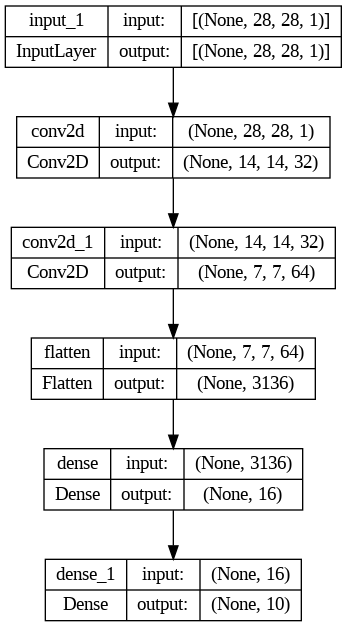

In [ ]:
tf.keras.utils.plot_model(encoder, show_shapes=True, show_layer_names=True)

## Decoder

In [ ]:
def build_decoder(latent_dims=LATENT_DIM):
  latent_inputs = Input(shape=(latent_dims,))
  x = Dense(16, activation="relu")(latent_inputs)
  x = Dense(7 * 7 * 64, activation="relu")(x)
  x = Reshape((7, 7, 64))(x)
  x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
  decoder = Model(latent_inputs, decoder_outputs, name="decoder")
  return decoder

decoder = build_decoder()
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 16)                176       
                                                                 
 dense_3 (Dense)             (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                 

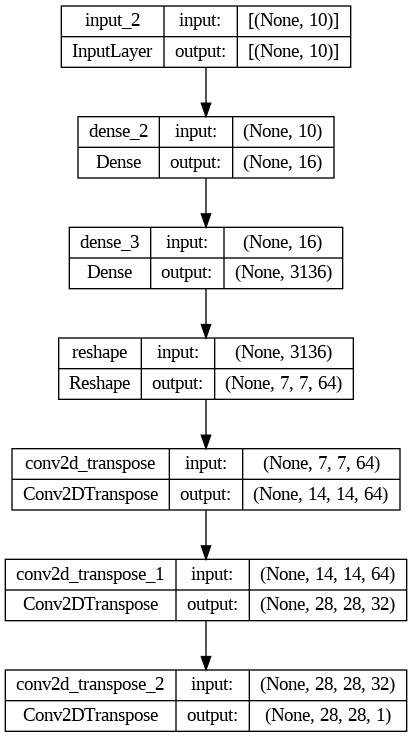

In [ ]:
tf.keras.utils.plot_model(decoder, show_shapes=True, show_layer_names=True)

## Model


In [ ]:
class AutoEncoder(Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(AutoEncoder, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

  def train_step(self, data):
    if isinstance(data, tuple):
        data   = data[0]
        labels = data[1]
    
    with tf.GradientTape() as tape:
        z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(data, reconstruction)
        )
        reconstruction_loss *= 28 * 28
    
    grads = tape.gradient(reconstruction_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    return {"reconstruction_loss": reconstruction_loss}

## Reconstruction Loss
* Measures how well a reconstructed image compares pixel by pixel to the original
* In this example we measure the average loss

![](https://user-images.githubusercontent.com/37034031/48129147-fb783e00-e2cb-11e8-856c-22b204afa87a.png)


## Training


In [ ]:
EPOCHS = 30
BATCH_SIZE = 128

In [ ]:
ae = AutoEncoder(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam())
history = ae.fit(mnist_digits,
                 mnist_labels,
                 epochs=EPOCHS, 
                 batch_size=BATCH_SIZE)

Epoch 1/30
547/547 [==============================] - 16s 8ms/step - reconstruction_loss: 202.1642
Epoch 2/30
547/547 [==============================] - 4s 7ms/step - reconstruction_loss: 149.6326
Epoch 3/30
547/547 [==============================] - 4s 7ms/step - reconstruction_loss: 140.5210
Epoch 4/30
547/547 [==============================] - 4s 7ms/step - reconstruction_loss: 137.1155
Epoch 5/30
547/547 [==============================] - 4s 7ms/step - reconstruction_loss: 135.0485
Epoch 6/30
547/547 [==============================] - 4s 7ms/step - reconstruction_loss: 133.5865
Epoch 7/30
547/547 [==============================] - 4s 7ms/step - reconstruction_loss: 132.6148
Epoch 8/30
547/547 [==============================] - 4s 7ms/step - reconstruction_loss: 131.7078
Epoch 9/30
547/547 [==============================] - 4s 8ms/step - reconstruction_loss: 131.0468
Epoch 10/30
547/547 [==============================] - 4s 7ms/step - reconstruction_loss: 130.4684
Epoch 11/30
547/54

## Testing

In [ ]:
def plot_performance(history, color_train='blue'):
  fig, ax = plt.subplots(figsize=(12,10))

  ax = plt.subplot(3, 1, 3)
  loss = history.history['reconstruction_loss']
  epochs = range(1, len(loss) + 1)    
  plt.plot(epochs, loss, 'b', color=color_train, label='Train')
  plt.xlabel('Epochs')
  plt.ylabel('Reconstruction Loss')
  plt.legend()

<ipython-input-12-315eb19aacac>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 1, 3)
<ipython-input-12-315eb19aacac>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color=color_train, label='Train')


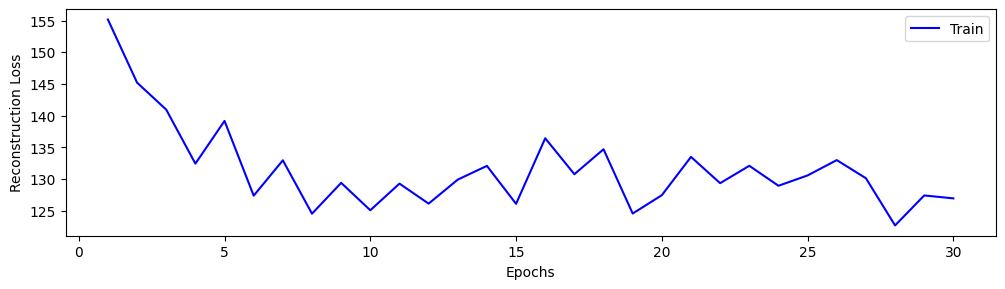

In [ ]:
plot_performance(history)

# Generate Image

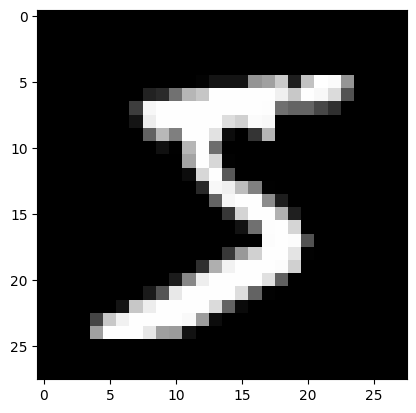

In [ ]:
digit = mnist_digits[0].reshape(28, 28)
plt.imshow(digit, cmap="Greys_r")

In [ ]:
enc = encoder(np.expand_dims(mnist_digits[0:1], -1))
enc.numpy()

array([[0.        , 0.        , 0.03039073, 2.5655754 , 0.        ,
        2.6564417 , 0.        , 0.        , 0.        , 0.9753225 ]],
      dtype=float32)

1/1 [==============================] - 0s 160ms/step


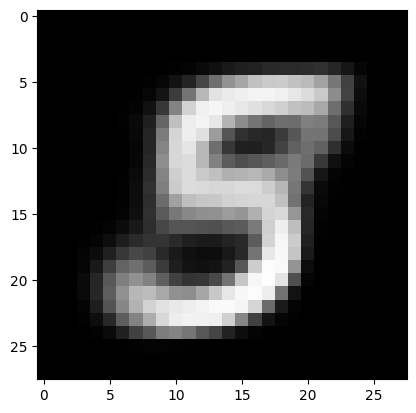

In [ ]:
dec = decoder.predict(enc)
plt.imshow(dec.reshape(28, 28), cmap="Greys_r")

## Value Hints

1/1 [==============================] - 0s 18ms/step


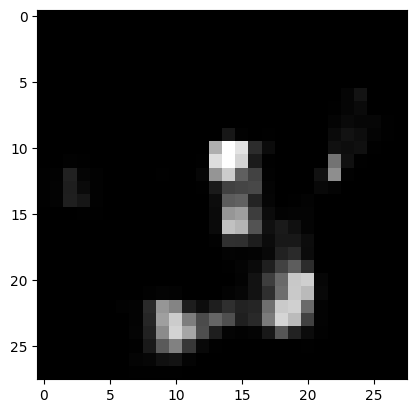

In [ ]:
noise = np.random.normal(size=(1, LATENT_DIM))
plt.imshow(decoder.predict(noise).reshape(28, 28), cmap='Greys_r')